# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [ ] Explore the data
    - [ ] examine for multicollinearity and determine truly independent variables
    - [ ] get to know the master dataset
    - [ ] feature engineering
- [ ] Modeling
    - [ ] create, fit, use XGBoost
    - [ ] gridsearch
    - [ ] retrain model using best hyperparameters
    - [ ] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# For data preparation
from sklearn.model_selection import train_test_split

# For modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05
mannwhitneyu_same = []
mannwhitneyu_diff = []

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

In [3]:
def viz_correlation(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    
    # Use the default Pearson for continuous variables
    corr_matrix = dfx.corr(method ='pearson')

    # Setup
    fig, ax = plt.subplots(figsize=(16,8))

    # vmin and vmax control the range of the colormap
    sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
               vmin=-1, vmax=1)

    plt.title(graph_title)

    # Add tight_layout to ensure the labels don't get cut off
    plt.tight_layout()
    plt.show()

In [4]:
def viz_scatter(df, graph_title, col1, col2):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[col1], df[col2], alpha=0.5)
    plt.xlabel(col1) #x label
    plt.ylabel(col2) #y label
    plt.title(graph_title)
    plt.show()

In [5]:
def viz_pairplot(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    plt.figure(figsize=(16, 8))
    sns.pairplot(dfx)
    plt.title(graph_title)
    plt.show()

In [6]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [8]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

In [9]:
def loop_mannwhitney(df1, df2):

    for column in df1.columns:
        stat, p = mannwhitneyu(df1[column], df2[column])

        if p > ALPHA:
            interpretation = 'SAME (fail to reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_same.append(column)
        else:
            interpretation = 'DIFFERENT (reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_diff.append(column)

In [10]:
def viz_boxplot(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.boxplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [11]:
def viz_violin(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.violinplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [12]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    return plot_importance(booster=booster, ax=ax, **kwargs)

## ACQUIRE DATA

In [13]:
# Get the PEIMS and STAAR datasets
ethnic = pd.read_csv('../data/inter/clean_ethnic_2019.csv')
staar = pd.read_csv('../data/inter/clean_staar_2019.csv')
peims = pd.read_csv('../data/inter/clean_peims_2019.csv')

In [14]:
ethnic.head()
staar.head()
peims.head()

,District,Percentage of Non-White Students
0,1902,0.145315
1,1903,0.211415
2,1904,0.213158
3,1906,0.268657
4,1907,0.717973


,District,Total Number of Students,Total Number of Passing Students
0,1902,932,842
1,1903,1991,1651
2,1904,1365,1064
3,1906,569,420
4,1907,5497,3274


,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Total Program Expenditures,Other Uses
0,1902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,304174,1858660,8558886,48633
1,1903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,339045,3262276,11696322,102465
2,1904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,571388,2445660,8802724,481
3,1906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,1412589,4021890,53786
4,1907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,1214433,10940857,36374344,0


## PREPARATION

In [15]:
ethnic = ethnic.astype({"District": str})
staar = staar.astype({"District": str})
peims = peims.astype({"District": str})

In [16]:
# Padd District numbers with 0's
ethnic['District'] = ethnic['District'].str.zfill(6)
staar['District'] = staar['District'].str.zfill(6)
peims['District'] = peims['District'].str.zfill(6)

In [17]:
ethnic.head()
ethnic.shape

staar.head()
staar.shape

peims.head()
peims.shape

,District,Percentage of Non-White Students
0,001902,0.145315
1,001903,0.211415
2,001904,0.213158
3,001906,0.268657
4,001907,0.717973


(1201, 2)

,District,Total Number of Students,Total Number of Passing Students
0,001902,932,842
1,001903,1991,1651
2,001904,1365,1064
3,001906,569,420
4,001907,5497,3274


(1251, 3)

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Total Program Expenditures,Other Uses
0,001902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,304174,1858660,8558886,48633
1,001903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,339045,3262276,11696322,102465
2,001904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,571388,2445660,8802724,481
3,001906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,1412589,4021890,53786
4,001907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,1214433,10940857,36374344,0


(1200, 33)

In [18]:
df = pd.merge(peims, staar, on=['District'])
df = pd.merge(df, ethnic, on=['District'])

$$E = B/(P/S)$$

$$E = \dfrac{B/(P/S)}{X}$$

In [19]:
df['Efficiency'] = (df['Total Program Expenditures'] / (df['Total Number of Passing Students'] / df['Total Number of Students']))/df['Percentage of Non-White Students']

In [20]:
df = df.drop(columns=['Total Program Expenditures',
                      'Total Number of Passing Students',
                      'Total Number of Students',
                      'Percentage of Non-White Students'
                     ])

In [21]:
df['Efficiency'].describe()

count    1.250000e+03
mean              inf
std               NaN
min      1.279219e+06
25%      1.698822e+07
50%      4.214819e+07
75%      1.107709e+08
max               inf
Name: Efficiency, dtype: float64

In [22]:
df['Efficiency'].quantile(q=.25)

16988223.566631433

In [23]:
df_pass = df[df['Efficiency'] <=  df['Efficiency'].quantile(q=.25)]
df_fail = df[df['Efficiency'] >   df['Efficiency'].quantile(q=.25)]

In [24]:
df_pass.shape
df_fail.shape

(313, 33)

(937, 33)

In [25]:
df_pass['Performance'] = 1
df_fail['Performance'] = 0

C:\Users\Dd\AppData\Local\Temp\ipykernel_1172\4042116679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pass['Performance'] = 1
C:\Users\Dd\AppData\Local\Temp\ipykernel_1172\4042116679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['Performance'] = 0


In [26]:
dff_pass = df_pass.copy()
dff_fail = df_fail.copy()

In [27]:
df_pass = df_pass.drop(columns=['Efficiency'])
df_fail = df_fail.drop(columns=['Efficiency'])

In [28]:
df_pass.head()

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Performance
19,005904,3481271,405820,437489,174214,2554924,41212,7951,0,251616,53537,0,59433,129778,204352,353938,318749,511827,7977,3500,0,1961002,10052,295410,274796,349642,49596,52162,0,308249,1197885,27531,1
21,007901,4728729,766725,789181,166853,3410008,62089,48861,19724,391750,152892,16888,62153,159498,437113,230575,503345,753567,29953,173072,0,2417784,10435,208744,533595,872522,53031,37766,67204,174891,2075516,83022,1
37,011905,3131432,402613,327969,98962,1997529,54863,154044,78113,221469,60118,0,765,110814,238107,146989,372736,371298,7866,142842,3423,1669697,13406,128705,320434,280379,8554,2811,126112,97262,1313616,44597,1
39,013801,3552237,495063,529092,246376,2515831,39974,71314,141152,214970,165189,0,16166,0,303325,99061,523868,599933,14827,99438,17720,2276410,17261,0,273023,583525,6596,0,0,0,1665953,0,1
41,013902,3381878,555065,237324,115179,2898047,1320,33399,0,195849,75064,0,68524,153812,116299,55849,242291,321631,4664,122553,144,880600,2229,0,180296,460025,1884,0,1748087,50552,965773,58110,1


In [29]:
df = pd.concat([df_pass, df_fail])

In [30]:
X = df.drop("Performance", axis=1)
y = df['Performance']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493, stratify=y)

## EXPLORATION

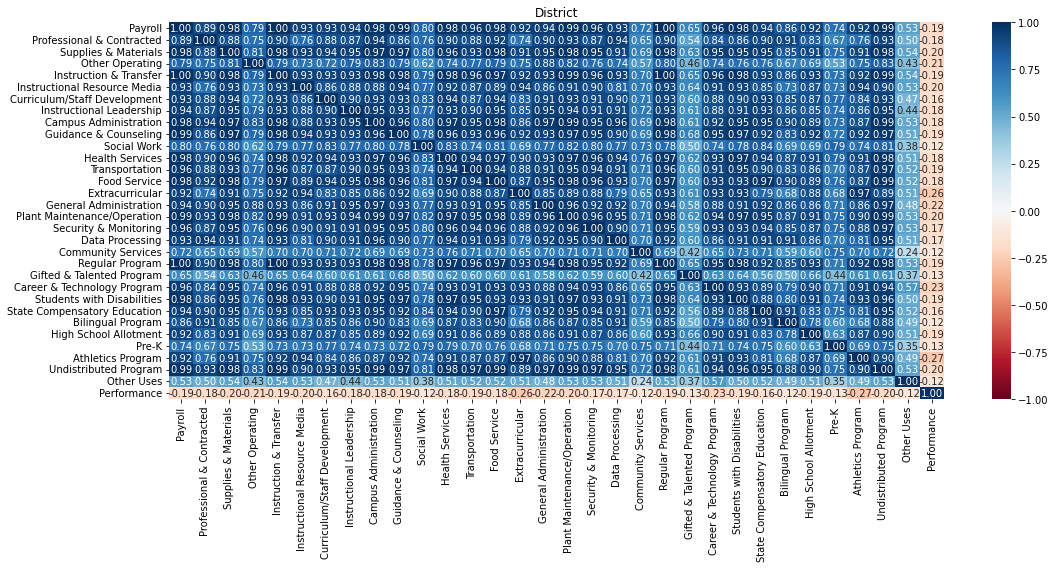

In [32]:
viz_correlation(df, 'District', 'Payroll', 'Professional & Contracted',
       'Supplies & Materials', 'Other Operating', 'Instruction & Transfer',
       'Instructional Resource Media', 'Curriculum/Staff Development',
       'Instructional Leadership', 'Campus Administration',
       'Guidance & Counseling', 'Social Work', 'Health Services',
       'Transportation', 'Food Service', 'Extracurricular',
       'General Administration', 'Plant Maintenance/Operation',
       'Security & Monitoring', 'Data Processing', 'Community Services',
       'Regular Program', 'Gifted & Talented Program',
       'Career & Technology Program', 'Students with Disabilities',
       'State Compensatory Education', 'Bilingual Program',
       'High School Allotment', 'Pre-K', 'Athletics Program',
       'Undistributed Program', 'Other Uses', 'Performance'
               )

In [33]:
df.columns

Index(['District', 'Payroll', 'Professional & Contracted',
       'Supplies & Materials', 'Other Operating', 'Instruction & Transfer',
       'Instructional Resource Media', 'Curriculum/Staff Development',
       'Instructional Leadership', 'Campus Administration',
       'Guidance & Counseling', 'Social Work', 'Health Services',
       'Transportation', 'Food Service', 'Extracurricular',
       'General Administration', 'Plant Maintenance/Operation',
       'Security & Monitoring', 'Data Processing', 'Community Services',
       'Regular Program', 'Gifted & Talented Program',
       'Career & Technology Program', 'Students with Disabilities',
       'State Compensatory Education', 'Bilingual Program',
       'High School Allotment', 'Pre-K', 'Athletics Program',
       'Undistributed Program', 'Other Uses', 'Performance'],
      dtype='object')

<Figure size 1152x576 with 0 Axes>

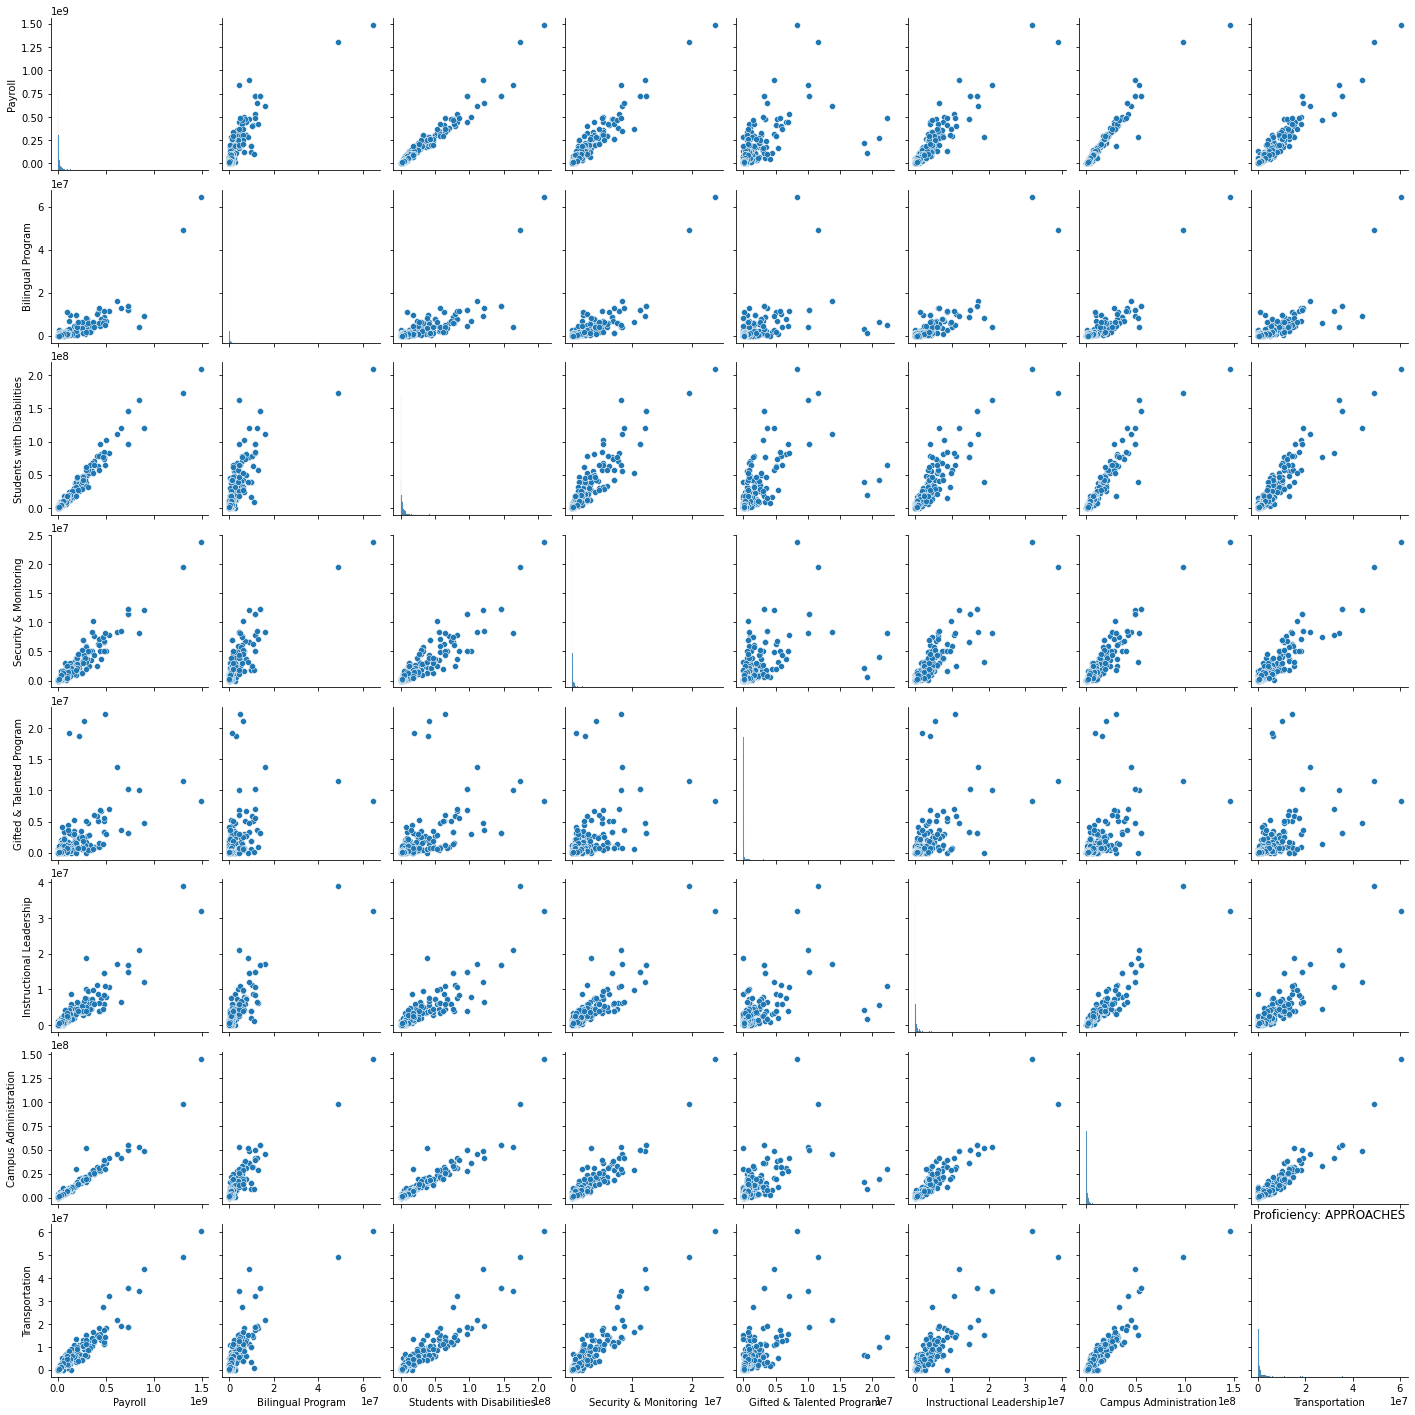

In [34]:
viz_pairplot(df, 'Proficiency: APPROACHES',
                 'Payroll',
                 'Bilingual Program',
                 'Students with Disabilities',
                 'Security & Monitoring',
                 'Gifted & Talented Program',
                 'Instructional Leadership',
                 'Campus Administration',
                 'Transportation'
            )

In [35]:
df_pass.head()

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Performance
19,005904,3481271,405820,437489,174214,2554924,41212,7951,0,251616,53537,0,59433,129778,204352,353938,318749,511827,7977,3500,0,1961002,10052,295410,274796,349642,49596,52162,0,308249,1197885,27531,1
21,007901,4728729,766725,789181,166853,3410008,62089,48861,19724,391750,152892,16888,62153,159498,437113,230575,503345,753567,29953,173072,0,2417784,10435,208744,533595,872522,53031,37766,67204,174891,2075516,83022,1
37,011905,3131432,402613,327969,98962,1997529,54863,154044,78113,221469,60118,0,765,110814,238107,146989,372736,371298,7866,142842,3423,1669697,13406,128705,320434,280379,8554,2811,126112,97262,1313616,44597,1
39,013801,3552237,495063,529092,246376,2515831,39974,71314,141152,214970,165189,0,16166,0,303325,99061,523868,599933,14827,99438,17720,2276410,17261,0,273023,583525,6596,0,0,0,1665953,0,1
41,013902,3381878,555065,237324,115179,2898047,1320,33399,0,195849,75064,0,68524,153812,116299,55849,242291,321631,4664,122553,144,880600,2229,0,180296,460025,1884,0,1748087,50552,965773,58110,1


In [36]:
loop_levene(df_pass.drop(columns=['District']),
            df_fail.drop(columns=['District']))

4.231622607133351e-10 - Payroll  -  significant - HETEROGENOUS
6.982520645011144e-09 - Professional & Contracted  -  significant - HETEROGENOUS
7.509046641891606e-11 - Supplies & Materials  -  significant - HETEROGENOUS
4.739363874199319e-11 - Other Operating  -  significant - HETEROGENOUS
3.117716164180412e-10 - Instruction & Transfer  -  significant - HETEROGENOUS
1.1017596155632959e-10 - Instructional Resource Media  -  significant - HETEROGENOUS
5.6989946362733805e-08 - Curriculum/Staff Development  -  significant - HETEROGENOUS
5.868226295844334e-10 - Instructional Leadership  -  significant - HETEROGENOUS
2.9610628439323152e-09 - Campus Administration  -  significant - HETEROGENOUS
3.922972411069322e-10 - Guidance & Counseling  -  significant - HETEROGENOUS
1.1169110632130734e-05 - Social Work  -  significant - HETEROGENOUS
5.9869979345962876e-09 - Health Services  -  significant - HETEROGENOUS
5.80902027681463e-10 - Transportation  -  significant - HETEROGENOUS
2.365938211634993

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:2604: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [37]:
loop_shapiro(df_pass.drop(columns=['District']))

7.03859894622192e-18 - Payroll  -  significant - ABNORMAL
1.932576562941657e-22 - Professional & Contracted  -  significant - ABNORMAL
2.5993821200722854e-15 - Supplies & Materials  -  significant - ABNORMAL
4.105832868349471e-24 - Other Operating  -  significant - ABNORMAL
4.540042830543234e-19 - Instruction & Transfer  -  significant - ABNORMAL
1.3042920184018547e-22 - Instructional Resource Media  -  significant - ABNORMAL
4.0773027781435346e-30 - Curriculum/Staff Development  -  significant - ABNORMAL
2.2281386860582173e-28 - Instructional Leadership  -  significant - ABNORMAL
3.0194947785660043e-17 - Campus Administration  -  significant - ABNORMAL
2.848604831922822e-25 - Guidance & Counseling  -  significant - ABNORMAL
3.5003108544167966e-34 - Social Work  -  significant - ABNORMAL
1.0730554452110836e-20 - Health Services  -  significant - ABNORMAL
5.461045495307326e-23 - Transportation  -  significant - ABNORMAL
5.1276410067803554e-23 - Food Service  -  significant - ABNORMAL
1.

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [38]:
loop_shapiro(df_fail.drop(columns=['District']))

0.0 - Payroll  -  significant - ABNORMAL
0.0 - Professional & Contracted  -  significant - ABNORMAL
0.0 - Supplies & Materials  -  significant - ABNORMAL
0.0 - Other Operating  -  significant - ABNORMAL
0.0 - Instruction & Transfer  -  significant - ABNORMAL
0.0 - Instructional Resource Media  -  significant - ABNORMAL
0.0 - Curriculum/Staff Development  -  significant - ABNORMAL
0.0 - Instructional Leadership  -  significant - ABNORMAL
0.0 - Campus Administration  -  significant - ABNORMAL
0.0 - Guidance & Counseling  -  significant - ABNORMAL
0.0 - Social Work  -  significant - ABNORMAL
0.0 - Health Services  -  significant - ABNORMAL
0.0 - Transportation  -  significant - ABNORMAL
0.0 - Food Service  -  significant - ABNORMAL
2.1019476964872256e-44 - Extracurricular  -  significant - ABNORMAL
0.0 - General Administration  -  significant - ABNORMAL
0.0 - Plant Maintenance/Operation  -  significant - ABNORMAL
0.0 - Security & Monitoring  -  significant - ABNORMAL
0.0 - Data Processing

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [39]:
loop_mannwhitney(df_pass.drop(columns=['District']),
                 df_fail.drop(columns=['District']))

Statistics=17933.500, p=0.000 - Payroll - DIFFERENT (reject H0)
Statistics=35638.500, p=0.000 - Professional & Contracted - DIFFERENT (reject H0)
Statistics=21335.500, p=0.000 - Supplies & Materials - DIFFERENT (reject H0)
Statistics=33693.500, p=0.000 - Other Operating - DIFFERENT (reject H0)
Statistics=19136.500, p=0.000 - Instruction & Transfer - DIFFERENT (reject H0)
Statistics=34550.500, p=0.000 - Instructional Resource Media - DIFFERENT (reject H0)
Statistics=50319.500, p=0.000 - Curriculum/Staff Development - DIFFERENT (reject H0)
Statistics=47071.500, p=0.000 - Instructional Leadership - DIFFERENT (reject H0)
Statistics=24151.500, p=0.000 - Campus Administration - DIFFERENT (reject H0)
Statistics=24185.000, p=0.000 - Guidance & Counseling - DIFFERENT (reject H0)
Statistics=97541.000, p=0.000 - Social Work - DIFFERENT (reject H0)
Statistics=29740.500, p=0.000 - Health Services - DIFFERENT (reject H0)
Statistics=34046.000, p=0.000 - Transportation - DIFFERENT (reject H0)
Statisti

In [40]:
df.columns

Index(['District', 'Payroll', 'Professional & Contracted',
       'Supplies & Materials', 'Other Operating', 'Instruction & Transfer',
       'Instructional Resource Media', 'Curriculum/Staff Development',
       'Instructional Leadership', 'Campus Administration',
       'Guidance & Counseling', 'Social Work', 'Health Services',
       'Transportation', 'Food Service', 'Extracurricular',
       'General Administration', 'Plant Maintenance/Operation',
       'Security & Monitoring', 'Data Processing', 'Community Services',
       'Regular Program', 'Gifted & Talented Program',
       'Career & Technology Program', 'Students with Disabilities',
       'State Compensatory Education', 'Bilingual Program',
       'High School Allotment', 'Pre-K', 'Athletics Program',
       'Undistributed Program', 'Other Uses', 'Performance'],
      dtype='object')

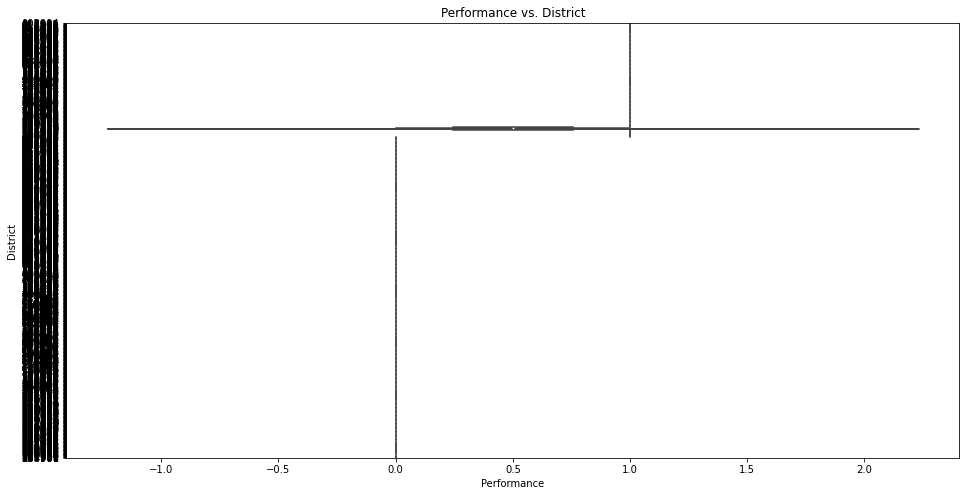

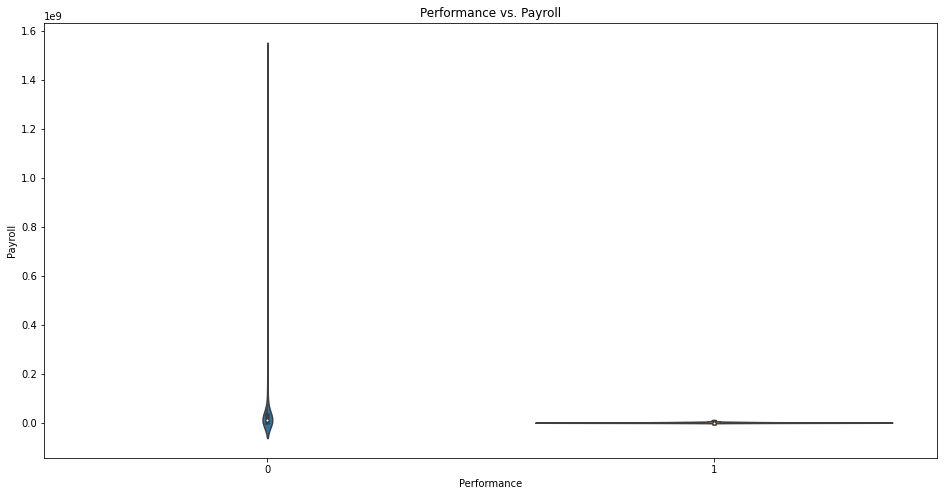

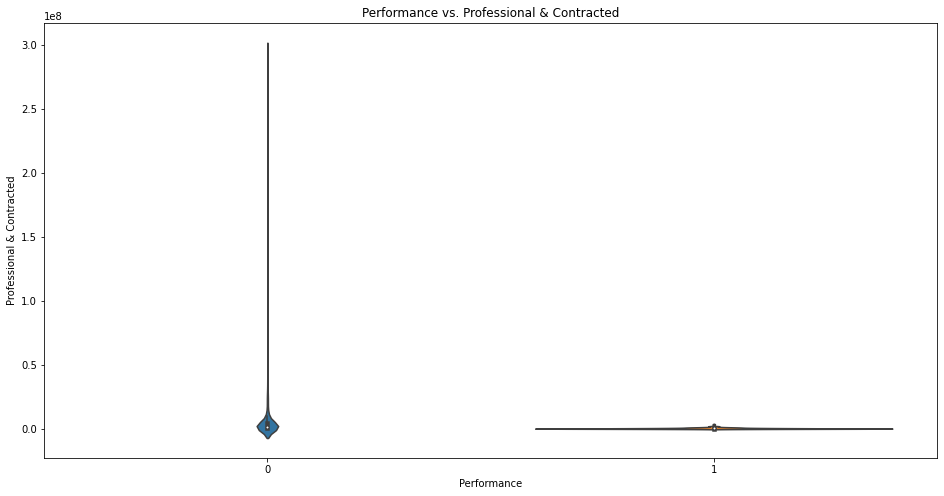

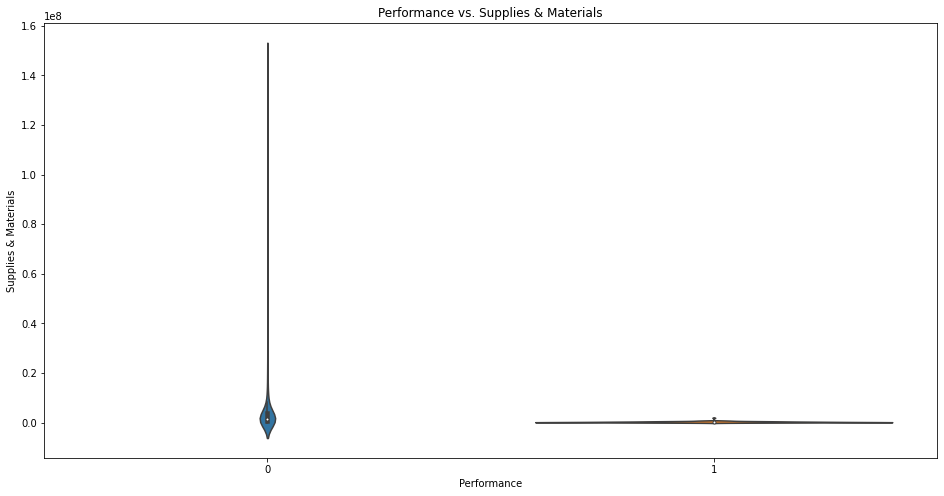

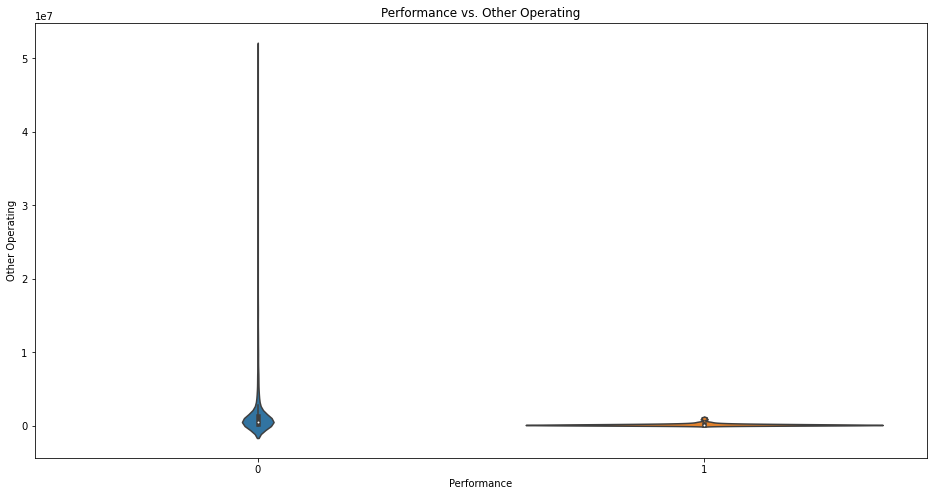

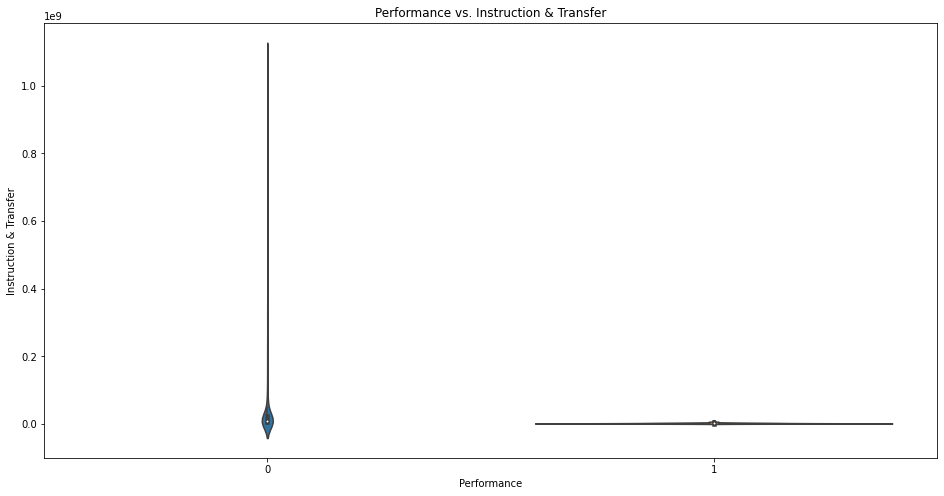

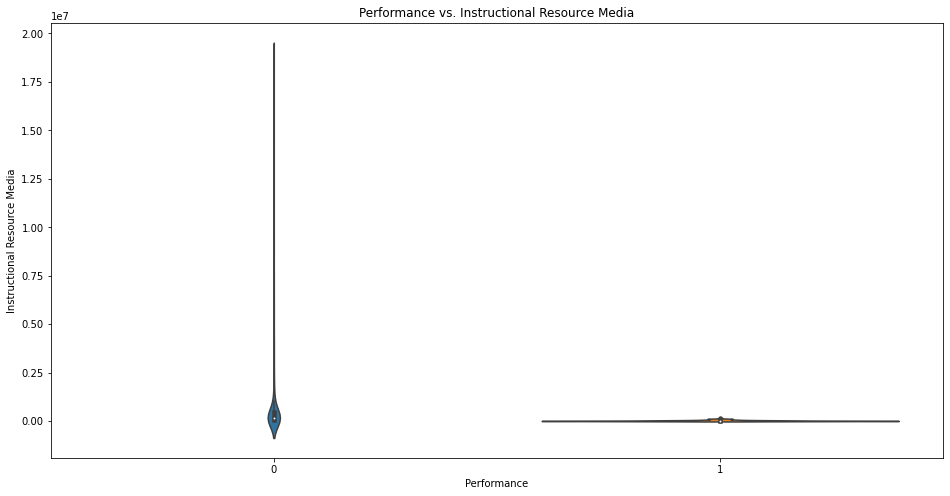

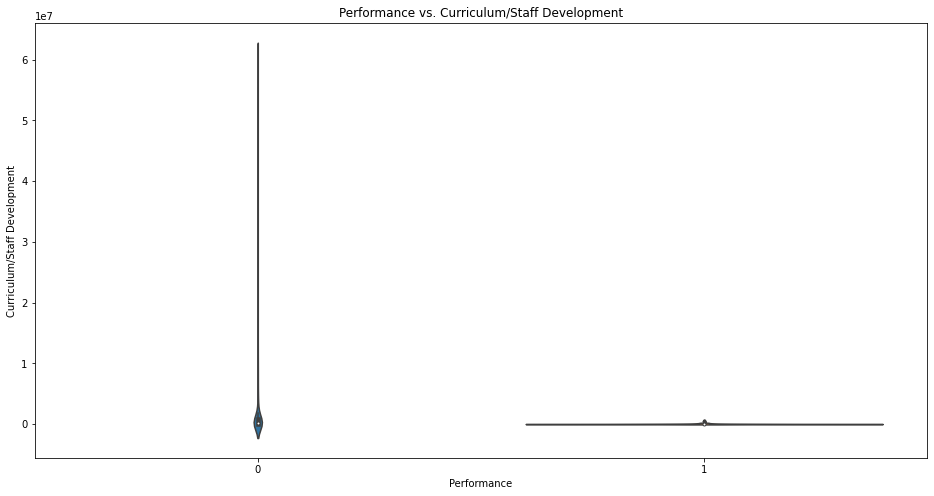

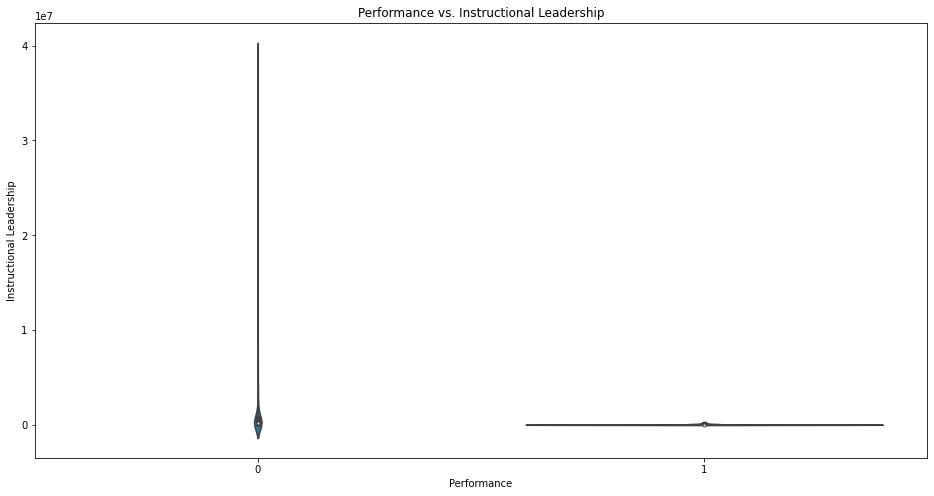

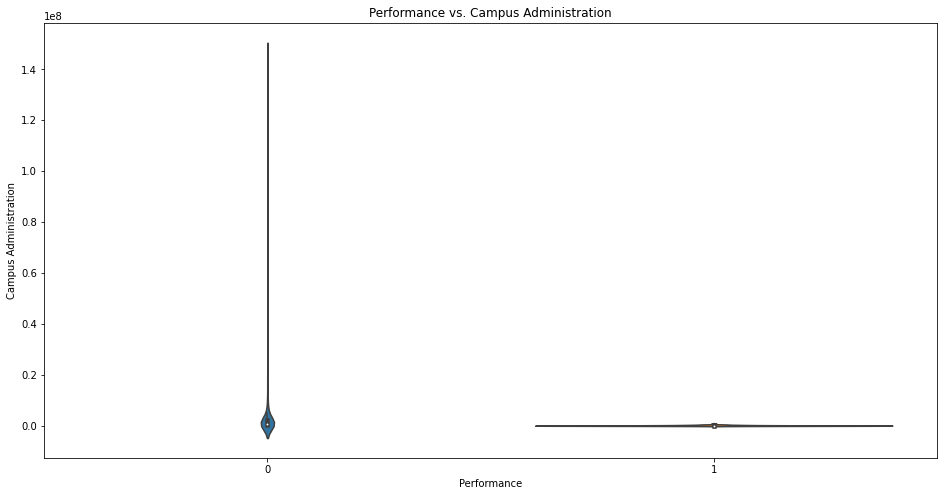

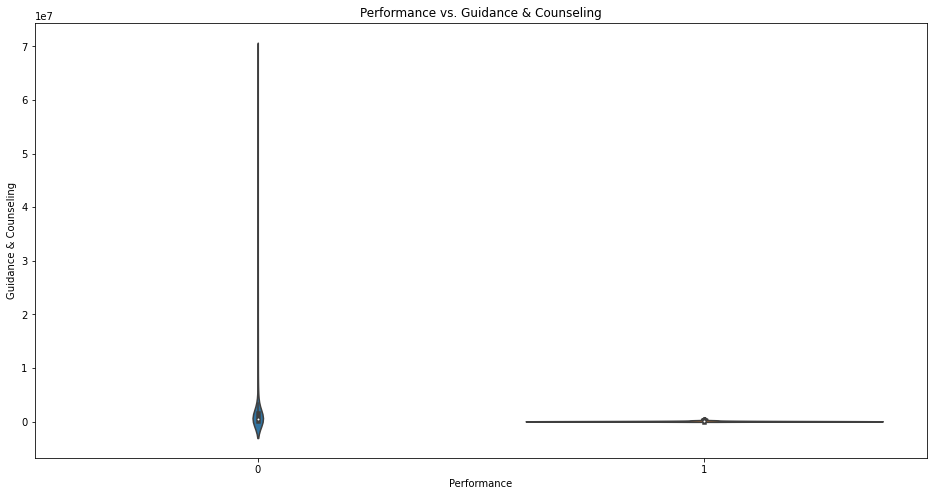

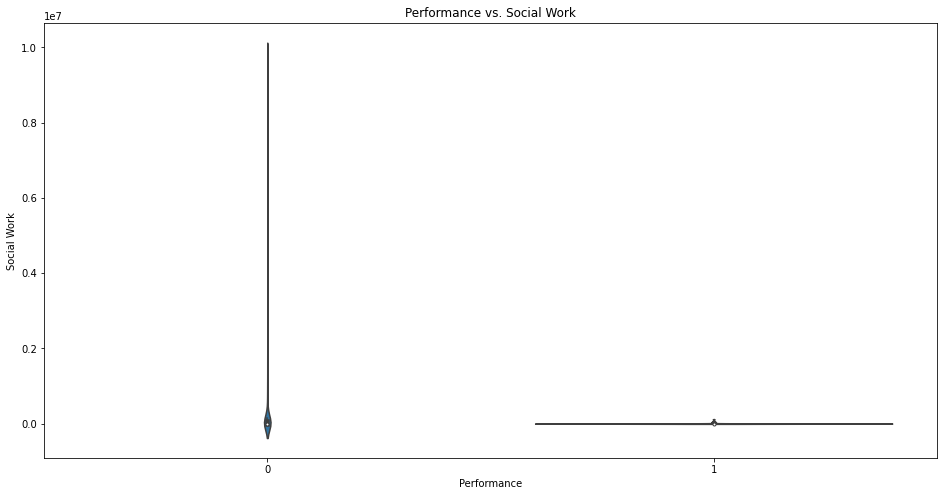

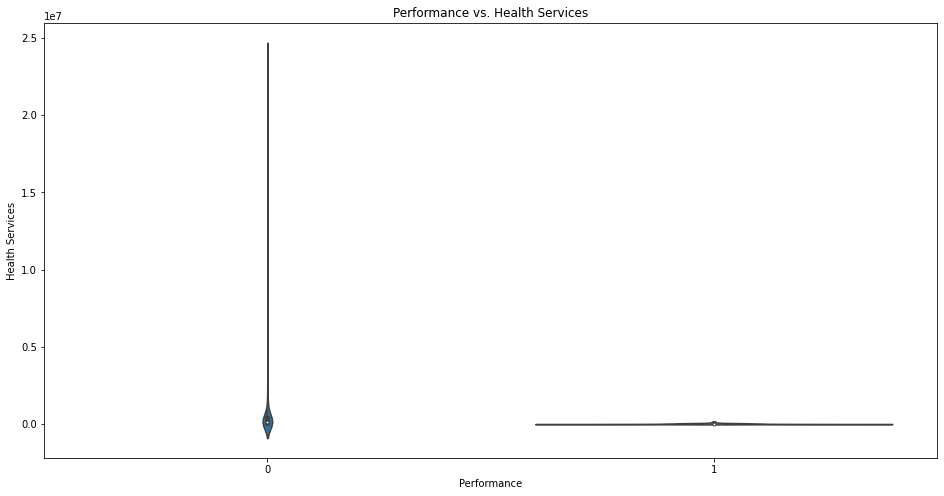

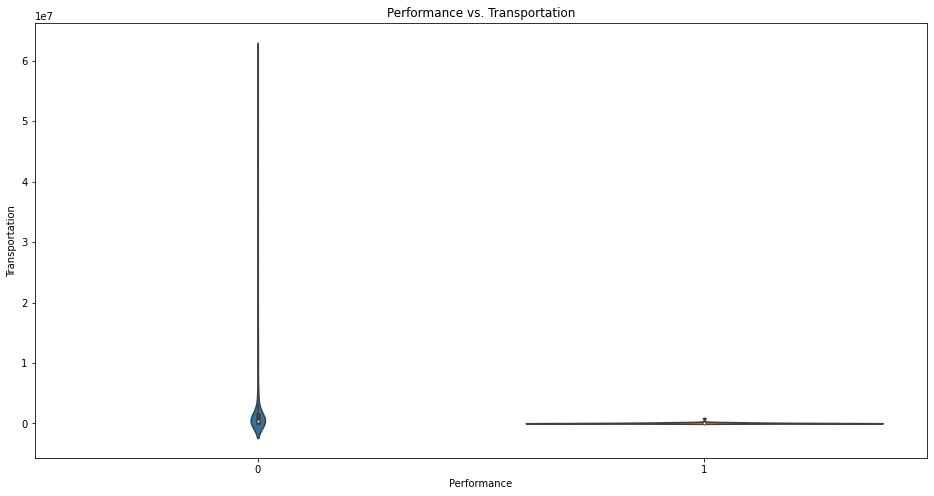

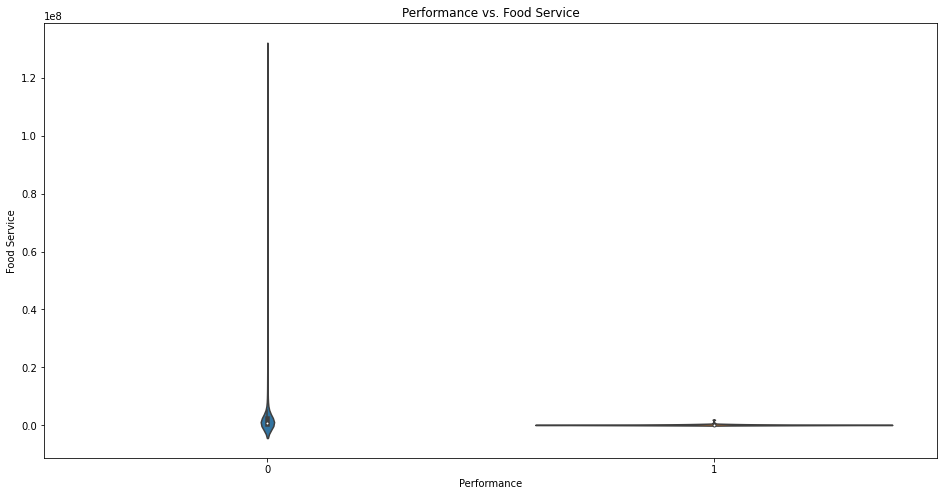

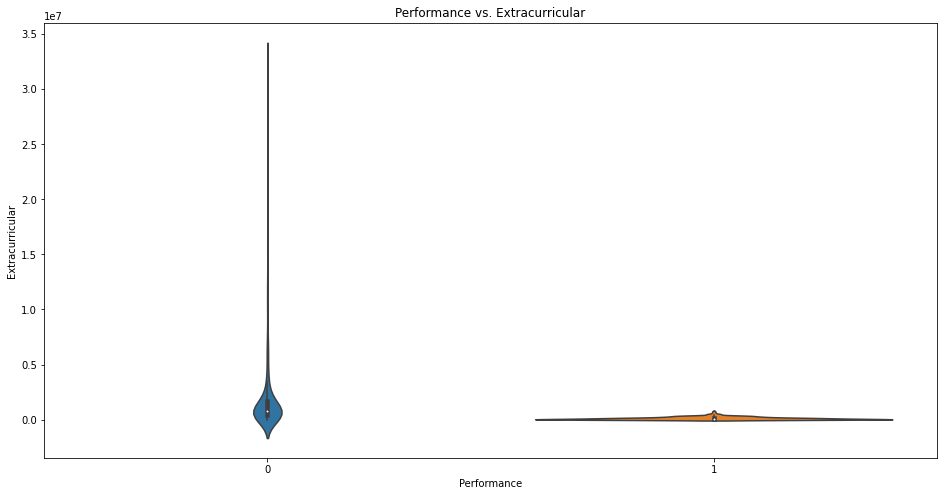

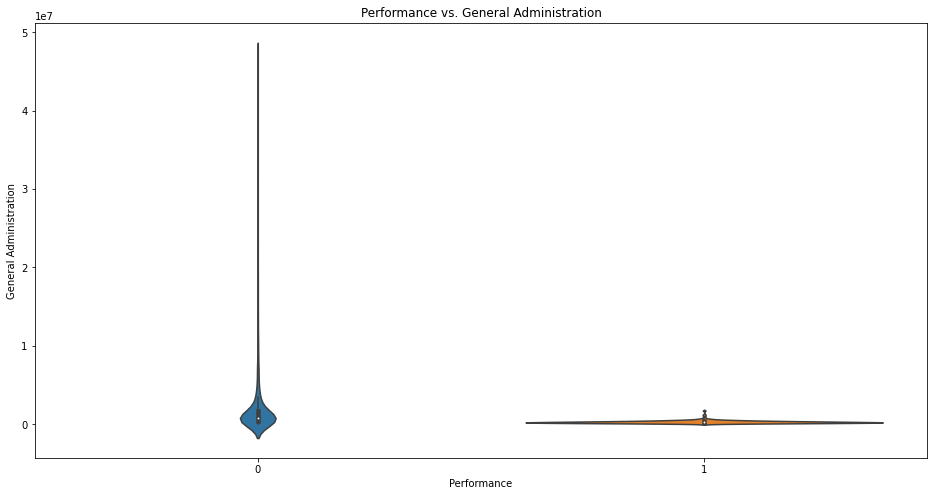

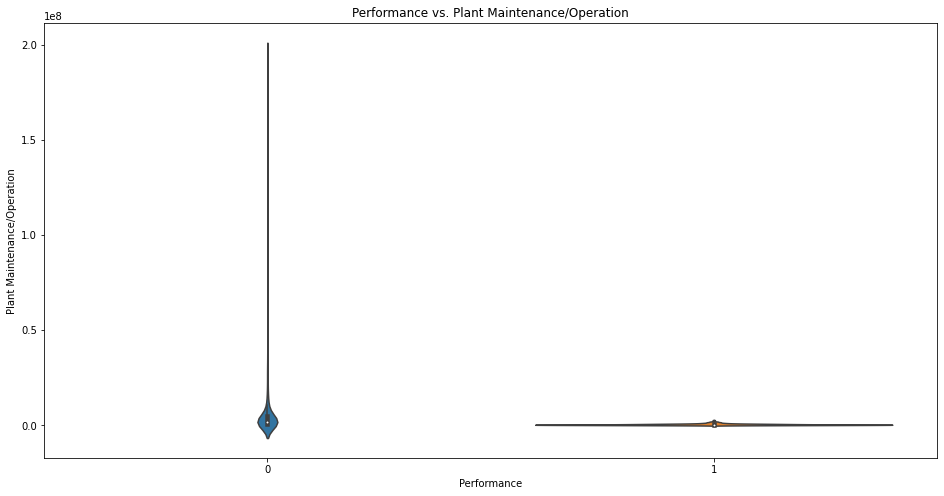

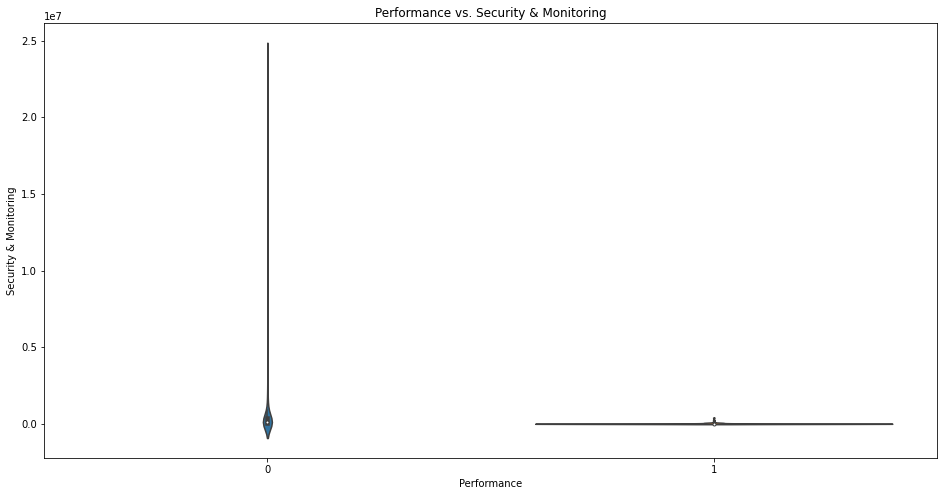

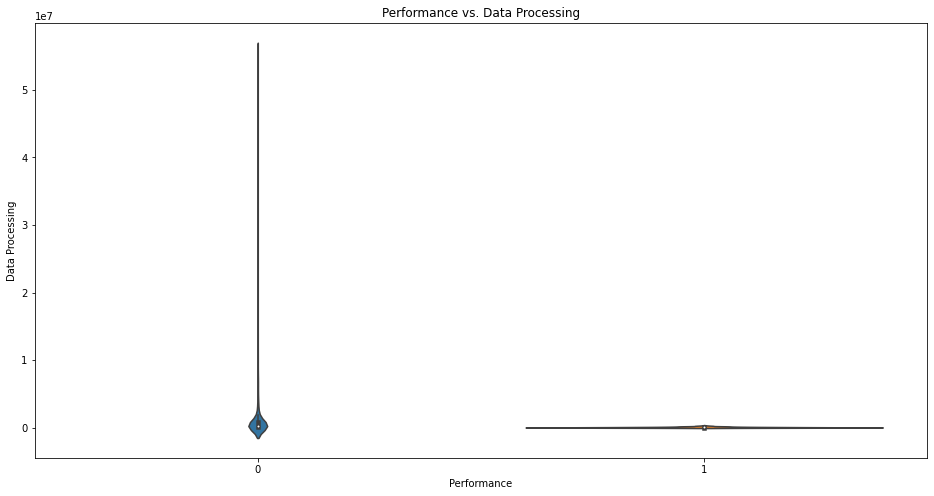

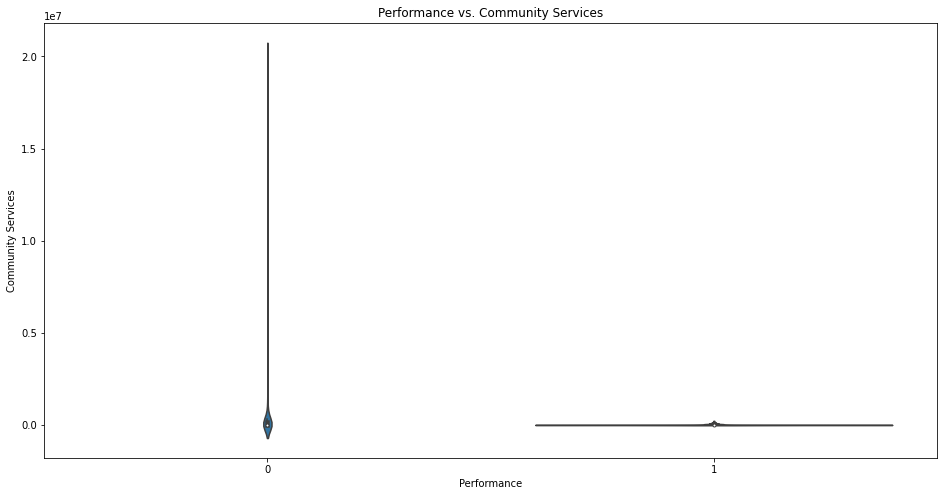

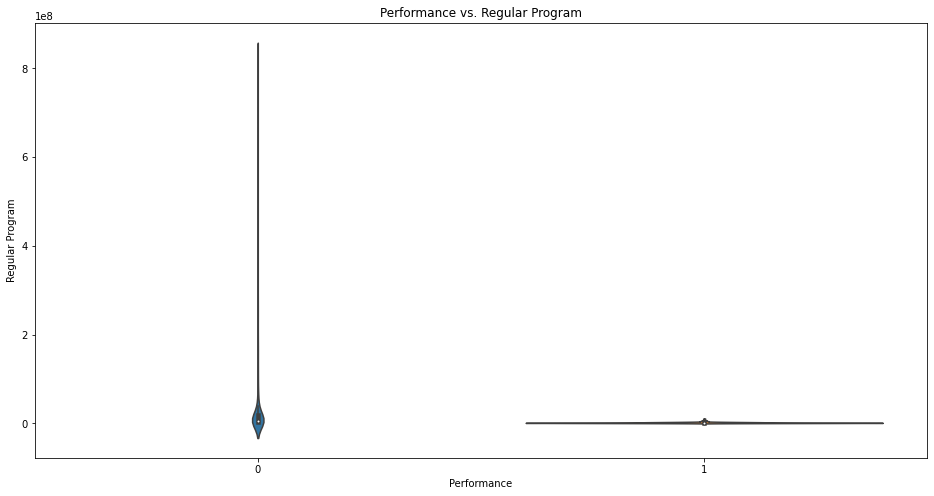

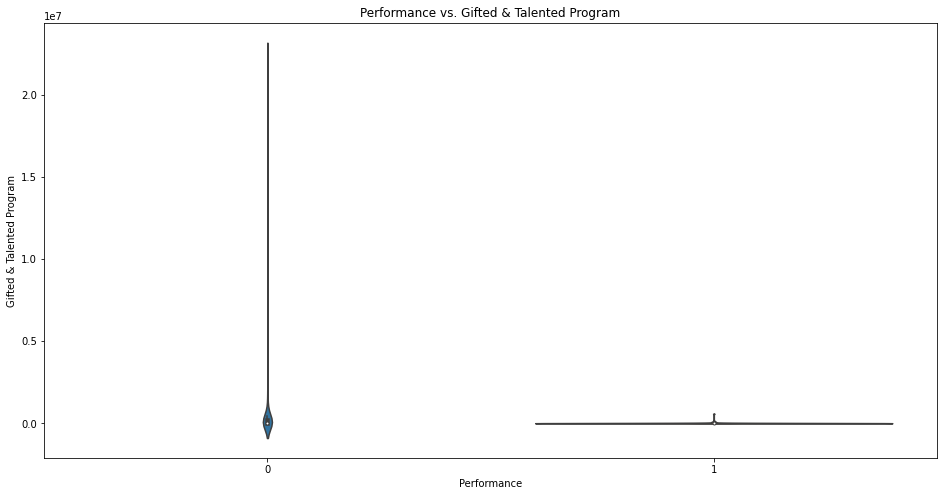

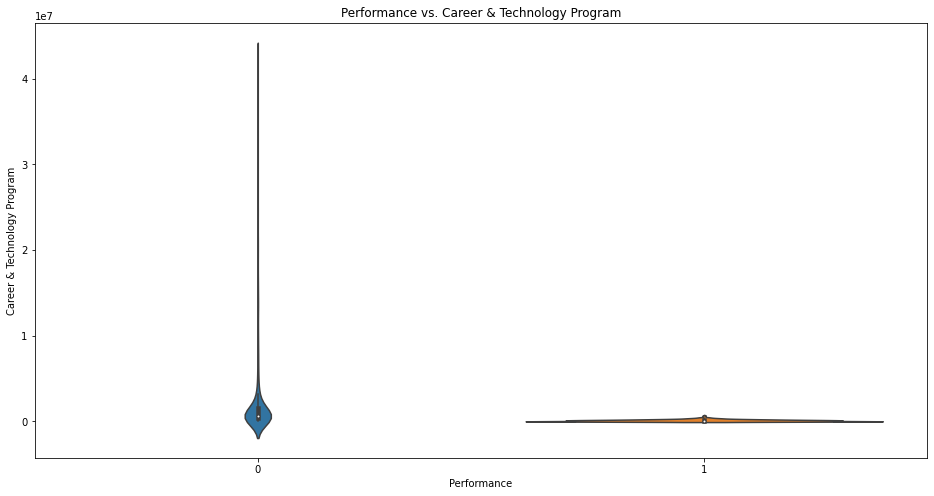

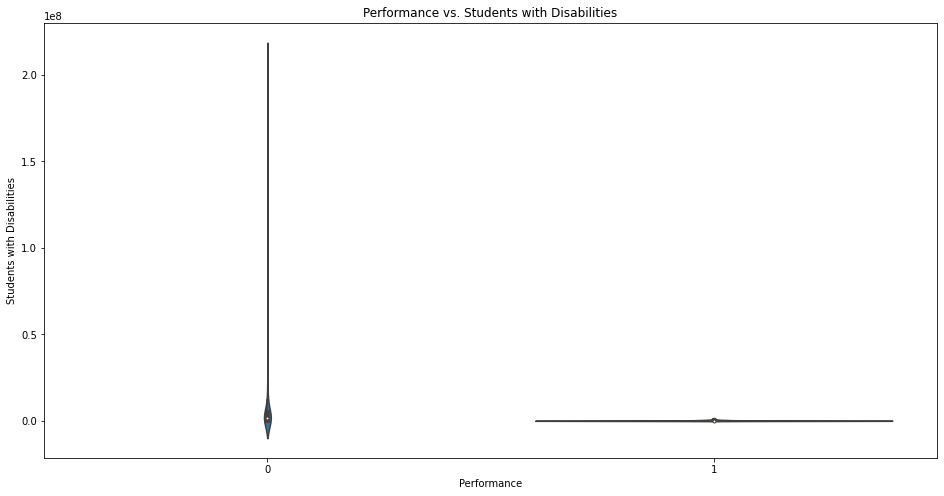

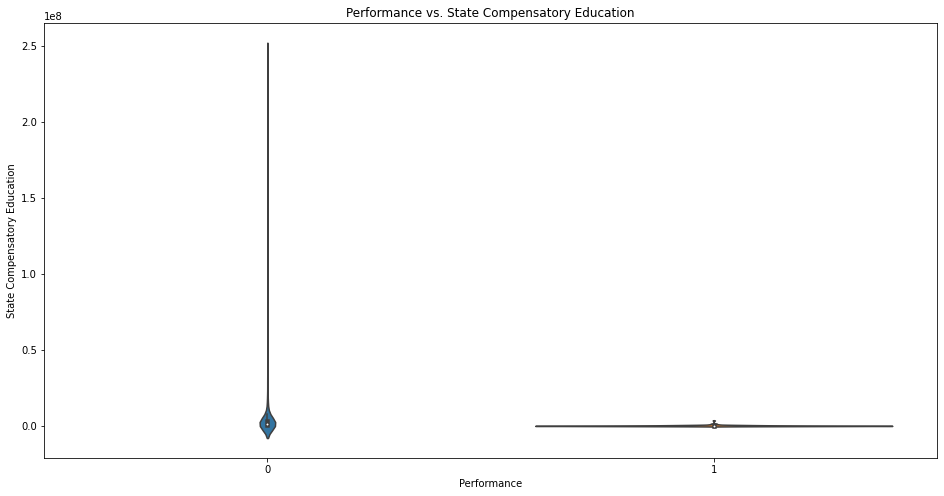

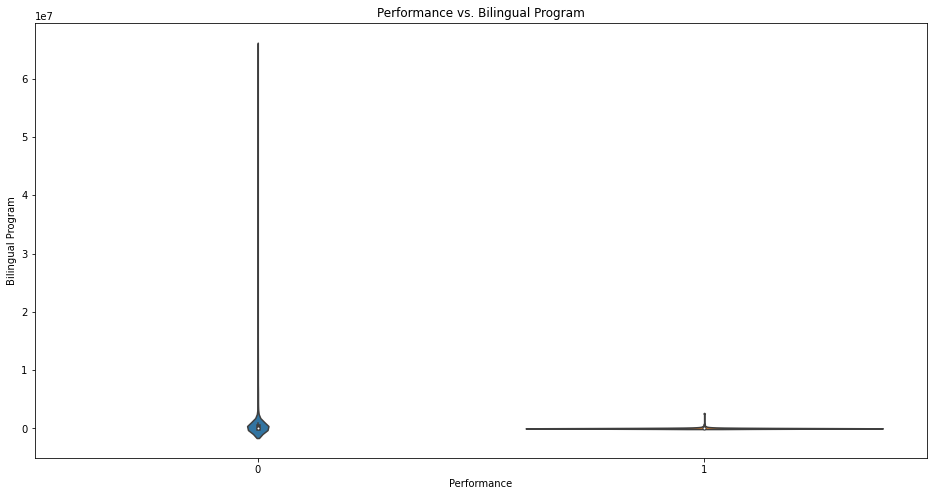

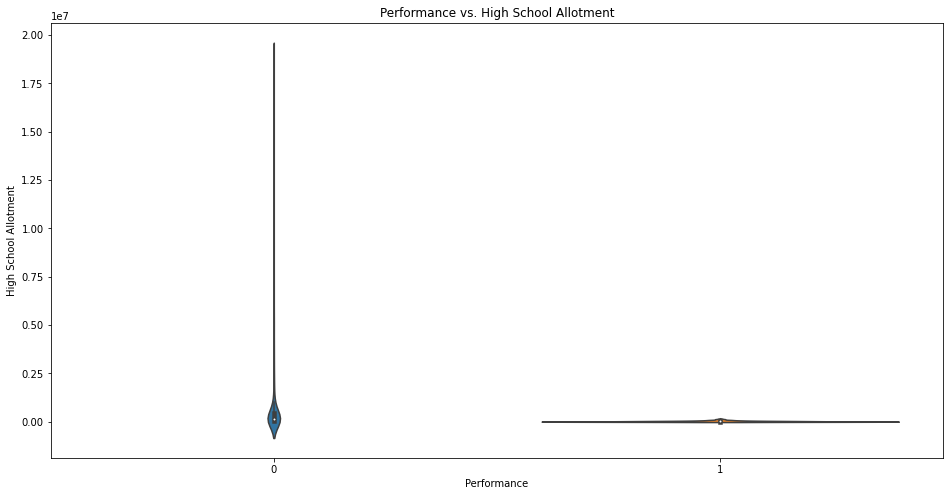

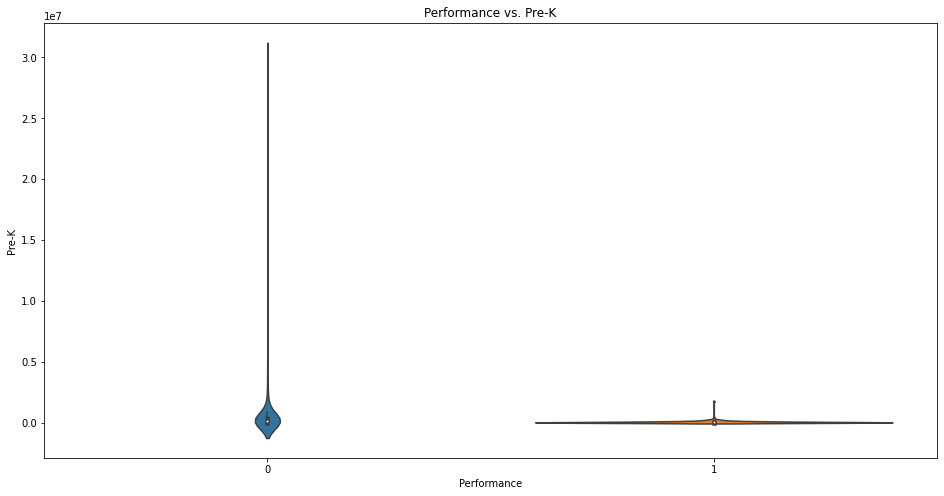

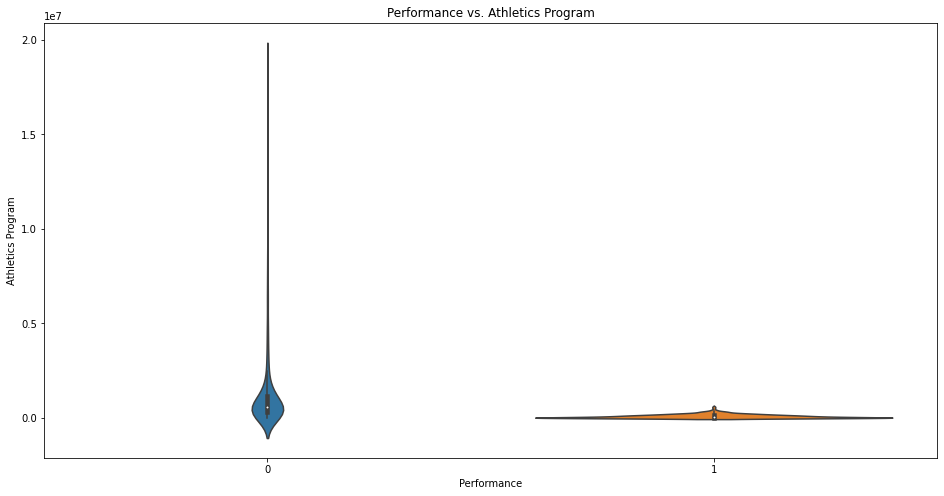

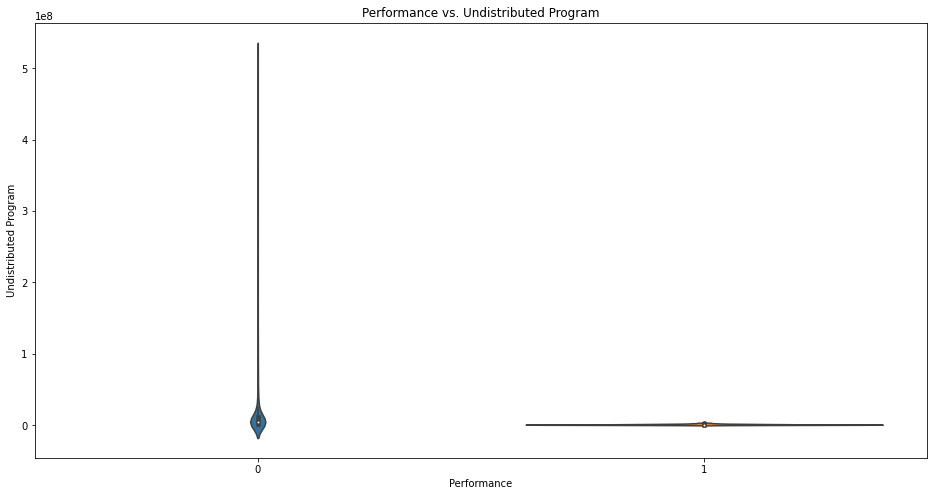

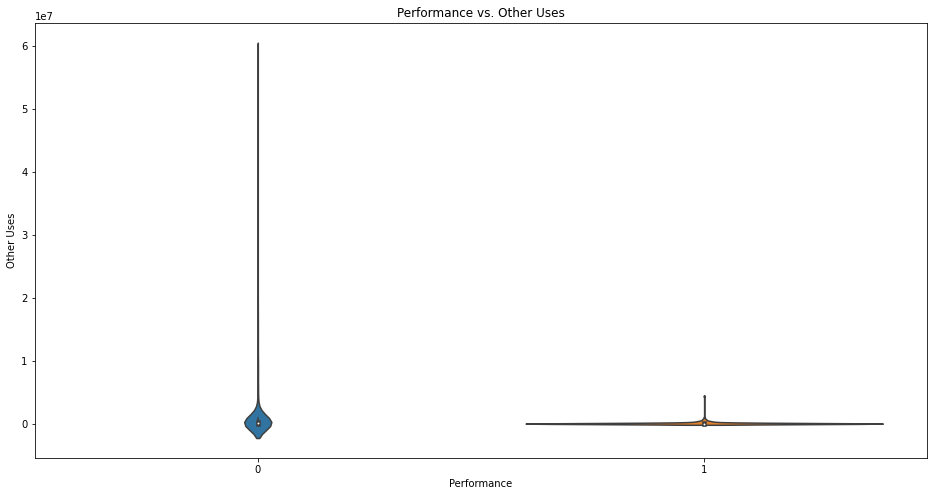

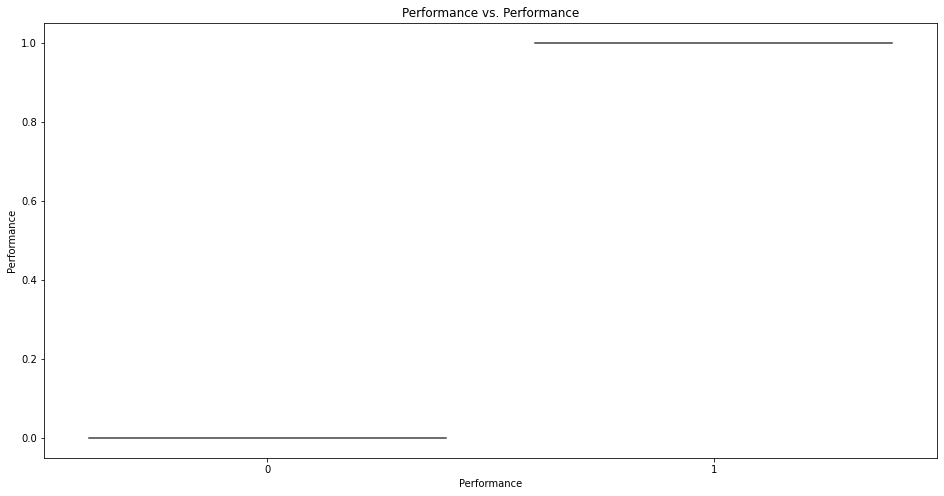

In [41]:
for column in df.columns:
    viz_violin(df, 'Performance', column, 'Performance vs. ' + column)

In [42]:
stat, p = mannwhitneyu(df_pass['Payroll'], df_fail['Payroll'])
p

7.64352731292459e-120

In [43]:
if p > ALPHA:
    interpretation = 'SAME (fail to reject H0)'
    print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + 'Payroll' + ' - ' + interpretation)
else:
    interpretation = 'DIFFERENT (reject H0)'
    print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + 'Payroll' + ' - ' + interpretation)

Statistics=17933.500, p=0.000 - Payroll - DIFFERENT (reject H0)


In [44]:
dff_pass.head()

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Efficiency,Performance
19,005904,3481271,405820,437489,174214,2554924,41212,7951,0,251616,53537,0,59433,129778,204352,353938,318749,511827,7977,3500,0,1961002,10052,295410,274796,349642,49596,52162,0,308249,1197885,27531,1.618369e+07,1
21,007901,4728729,766725,789181,166853,3410008,62089,48861,19724,391750,152892,16888,62153,159498,437113,230575,503345,753567,29953,173072,0,2417784,10435,208744,533595,872522,53031,37766,67204,174891,2075516,83022,1.408102e+07,1
37,011905,3131432,402613,327969,98962,1997529,54863,154044,78113,221469,60118,0,765,110814,238107,146989,372736,371298,7866,142842,3423,1669697,13406,128705,320434,280379,8554,2811,126112,97262,1313616,44597,1.244746e+07,1
39,013801,3552237,495063,529092,246376,2515831,39974,71314,141152,214970,165189,0,16166,0,303325,99061,523868,599933,14827,99438,17720,2276410,17261,0,273023,583525,6596,0,0,0,1665953,0,9.028057e+06,1
41,013902,3381878,555065,237324,115179,2898047,1320,33399,0,195849,75064,0,68524,153812,116299,55849,242291,321631,4664,122553,144,880600,2229,0,180296,460025,1884,0,1748087,50552,965773,58110,7.997852e+06,1


In [45]:
dff_pass.sort_values('Efficiency', ascending=True).head()

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Efficiency,Performance
725,133905,253194,86426,14227,12988,235434,0,1,0,34752,0,0,1400,24547,0,0,47785,22776,0,140,0,267799,0,0,3488,0,300,0,0,0,95248,0,1.279219e+06,1
686,125906,949225,176342,164609,61678,690186,0,3990,19546,100672,17335,0,717,39463,100755,37006,119887,180810,0,41487,0,617422,4590,0,31041,176812,2581,0,0,0,519408,22000,1.799443e+06,1
338,066005,370064,176735,74522,36385,199523,0,2500,0,53782,1457,0,0,57003,57085,0,162322,106954,0,16675,405,139899,0,0,7761,95398,14609,0,0,0,400039,29813,1.973118e+06,1
671,122902,1042082,176336,103585,90395,720572,6799,6868,0,95424,27043,0,1577,59737,10084,61037,221105,158390,424,43338,0,643031,0,27043,14822,89398,8949,2348,72692,61037,493078,2746,2.069894e+06,1
133,022903,646013,124194,65547,65042,360780,32104,34996,0,137278,7830,0,2824,4714,0,7935,200290,88276,1200,22569,0,486144,0,0,50435,47168,0,0,0,0,317049,0,2.137603e+06,1


In [46]:
dff_fail.sort_values('Efficiency', ascending=False).head(100)

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Efficiency,Performance
224,046802,6446147,1454768,555035,267478,5602113,0,109007,126990,885550,608961,0,713,0,10033,0,623284,530188,1025,175505,50059,1747625,0,129395,3654736,1787212,36075,65532,0,0,1302853,0,inf,0
475,093904,20908258,5215751,3355252,708552,16274149,233496,397678,697148,1868703,1154057,0,317941,1644363,1874768,1059777,1136258,2971014,157517,343214,57730,12196925,32447,1434647,3689383,2823299,221086,396988,368318,920469,8104251,0,inf,0
1112,227806,8779505,523406,364729,621827,6274196,0,726721,26130,1157648,620539,0,412,0,0,0,975780,175162,0,332879,0,3656438,0,0,3470405,1557087,24753,94389,0,0,1486395,0,inf,0
25,007905,27071297,2984059,2665551,1128448,17837015,452111,404203,716646,1843982,1683567,92933,160854,1153800,1782104,1535926,1373143,4034774,320565,415278,42454,12695569,98194,1406326,5528195,2462303,120148,323050,739657,934296,9541617,0,inf,0
196,040901,4081844,940752,456846,201637,3052638,22708,17029,26168,475319,105851,0,67914,94682,337708,244337,374734,716277,3652,141079,983,2194505,7215,279272,139526,1150630,26927,44339,23799,205293,1609573,8177,inf,0
267,057814,7479227,293375,157679,131298,5516601,0,7740,292619,873635,673738,0,0,100613,0,0,446552,65906,84175,0,0,5071904,0,71945,1079077,1154015,87610,78438,0,0,518590,0,inf,0
852,167902,4245671,639303,253319,174661,3056541,394,9271,188860,577520,252220,0,11007,78252,97868,106182,554204,248301,5958,126376,0,1020790,2326,298848,1205447,1496876,14288,53438,23035,84881,1113025,38618,inf,0
785,152901,200466567,47676753,20385099,5627345,156326987,4007361,8133133,4044387,16645470,11045813,601960,3496701,5019463,15886619,6788850,5995492,23924617,2135664,3279334,6823913,122042863,1057634,7857051,44745069,28061191,466995,3837472,5775580,4757321,55554588,0,inf,0
1179,238902,16139168,1187740,2925991,687269,11442304,249222,81865,143640,1275288,495824,20653,255708,661848,1362005,1422667,592806,2259689,189723,401083,85843,8230313,37756,505901,2475858,2481560,189508,185660,0,940332,5893280,68066,inf,0
506,101811,6862107,503205,218653,44121,4520964,59267,354229,224850,842624,1099406,40423,0,14148,0,0,421048,23400,0,27474,253,3860636,0,0,1015156,2096163,35505,166306,0,0,454320,0,inf,0


In [47]:
districts = pd.read_csv('../data/in/Enrollment Report_Statewide_Districts_Grade_Ethnicity_2018-2019.csv', skiprows=4)

In [48]:
show_values(districts, ['DISTRICT'])

DISTRICT
14906.0     105
220902.0    105
79907.0     105
101914.0    105
101915.0    105
15915.0     105
220901.0    104
71902.0     104
43901.0     104
220907.0    104
220918.0    104
57912.0     104
43910.0     104
79901.0     104
43905.0     104
170902.0    104
15910.0     104
57905.0     104
227901.0    104
101919.0    104
101912.0    104
227904.0    104
57910.0     103
57914.0     103
71909.0     103
101913.0    103
220916.0    103
220908.0    103
101907.0    103
246909.0    103
101903.0    103
57909.0     103
101902.0    103
123910.0    103
43907.0     103
220905.0    103
50910.0     102
84910.0     102
61901.0     102
246913.0    102
178904.0    102
61911.0     102
188901.0    102
57916.0     102
71905.0     102
61902.0     102
15916.0     102
101917.0    102
68901.0     101
20901.0     101
152901.0    101
220906.0    101
221901.0    101
220912.0    101
94902.0     100
101911.0    100
46902.0      99
14903.0      99
243905.0     99
126902.0     99
43914.0      99
92903.0      99

In [49]:
districts.dropna(inplace=True)

In [50]:
districts['DISTRICT'] = districts['DISTRICT'].astype('int64').astype('str')

In [51]:
districts.dtypes

YEAR               object
REGION            float64
COUNTY NAME        object
DISTRICT           object
DISTRICT NAME      object
ETHNICITY          object
CHARTER STATUS     object
GRADE              object
ENROLLMENT        float64
dtype: object

In [52]:
districts = districts[['DISTRICT',
          'DISTRICT NAME'
        ]]

In [53]:
districts.head()

,DISTRICT,DISTRICT NAME
0,1902,CAYUGA ISD
1,1902,CAYUGA ISD
2,1902,CAYUGA ISD
3,1902,CAYUGA ISD
4,1902,CAYUGA ISD


In [54]:
districts['DISTRICT'] = districts['DISTRICT'].str.zfill(6)

In [55]:
districts.head()

,DISTRICT,DISTRICT NAME
0,001902,CAYUGA ISD
1,001902,CAYUGA ISD
2,001902,CAYUGA ISD
3,001902,CAYUGA ISD
4,001902,CAYUGA ISD


In [56]:
districts = districts.rename(columns={'DISTRICT':'District',
                        'DISTRICT NAME':'District Name'
                        })

In [57]:
districts.drop_duplicates(keep='first', inplace=True)

In [58]:
import math
dff_fail = dff_fail[dff_fail['Efficiency'] != math.inf]

In [59]:
dff_pass = dff_pass.sort_values('Efficiency', ascending=True).head(20)
dff_fail = dff_fail.sort_values('Efficiency', ascending=False).head(20)

In [60]:
dfx_pass = pd.merge(districts, dff_pass, how='inner', on=['District'])
dfx_fail = pd.merge(districts, dff_fail, how='inner', on=['District'])

In [61]:
dfx_pass.sort_values('Efficiency', ascending=True)

,District,District Name,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Efficiency,Performance
16,133905,DIVIDE ISD,253194,86426,14227,12988,235434,0,1,0,34752,0,0,1400,24547,0,0,47785,22776,0,140,0,267799,0,0,3488,0,300,0,0,0,95248,0,1.279219e+06,1
14,125906,LA GLORIA ISD,949225,176342,164609,61678,690186,0,3990,19546,100672,17335,0,717,39463,100755,37006,119887,180810,0,41487,0,617422,4590,0,31041,176812,2581,0,0,0,519408,22000,1.799443e+06,1
4,066005,RAMIREZ CSD,370064,176735,74522,36385,199523,0,2500,0,53782,1457,0,0,57003,57085,0,162322,106954,0,16675,405,139899,0,0,7761,95398,14609,0,0,0,400039,29813,1.973118e+06,1
13,122902,VALENTINE ISD,1042082,176336,103585,90395,720572,6799,6868,0,95424,27043,0,1577,59737,10084,61037,221105,158390,424,43338,0,643031,0,27043,14822,89398,8949,2348,72692,61037,493078,2746,2.069894e+06,1
2,022903,SAN VICENTE ISD,646013,124194,65547,65042,360780,32104,34996,0,137278,7830,0,2824,4714,0,7935,200290,88276,1200,22569,0,486144,0,0,50435,47168,0,0,0,0,317049,0,2.137603e+06,1
17,152802,RISE ACADEMY,1723949,361714,173320,179282,1612919,0,52094,34090,63784,5918,0,0,0,26094,36177,261067,253770,18261,74091,0,1027957,0,0,159601,467480,0,0,113767,917,668543,0,2.227261e+06,1
0,015833,HENRY FORD ACADEMY ALAMEDA SCHOOL,623120,448373,31314,390273,637969,0,50904,3226,209397,68850,0,5429,13274,67180,8085,145811,242261,1547,38645,502,698357,0,118073,78908,55155,0,29629,0,5485,507473,20486,2.448113e+06,1
12,101872,ETOILE ACADEMY CHARTER SCHOOL,446477,444670,259102,51763,472700,0,5072,0,146244,0,0,0,58400,42240,1235,178174,265068,6024,22147,4708,333729,0,0,34252,156272,10261,0,0,0,667498,0,2.493536e+06,1
8,101815,ALIEF MONTESSORI COMMUNITY SCHOOL,1473460,289189,129629,223429,1356955,39569,13899,8887,8368,0,0,0,0,119167,57966,176207,326613,8076,0,0,714326,0,0,98882,514102,168978,0,0,0,619419,0,2.505849e+06,1
11,101849,ACCELERATED INTERMEDIATE ACADEMY,1465215,390014,54486,204284,1265325,0,0,0,184084,0,0,60,0,172518,0,223548,246866,0,21598,0,402622,0,0,209627,700622,139590,0,0,0,661538,0,2.641484e+06,1


In [62]:
dfx_fail.sort_values('Efficiency', ascending=False)

,District,District Name,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Efficiency,Performance
13,220905,FORT WORTH ISD,729137493,62605706,81443908,15974012,493084038,11975642,33078019,15007735,49739548,47373498,7830547,9502098,18839138,54802027,15833261,18919424,78708120,11401692,13704453,9361879,398743514,10225904,20650586,96677012,119815135,11791478,8931939,12818935,14166020,195340596,990226,7.277575e+09,0
0,015907,SAN ANTONIO ISD,477370756,52422184,59397230,6843275,306941477,6340157,33088283,14559137,36141990,23708254,5051297,9459145,11229028,42886161,12440414,16975311,52740541,6641841,9810678,8019731,230732960,3345350,13354302,76945318,62530259,8971106,6680185,29942602,8569334,154962029,30545,5.005766e+09,0
16,227901,AUSTIN ISD,726327102,66353497,58151481,15235836,457723297,10920992,22823762,16794186,55012000,28932127,6672637,13478503,35746126,39295383,17896205,22951215,83376836,12289509,22117961,20037177,335821423,3186681,15966224,146714815,85966700,13792354,5104393,24276576,14098994,221139756,5000000,4.472956e+09,0
8,101912,HOUSTON ISD,1491157019,294666292,146920059,27977895,1085122989,9855916,60503235,31900245,145714852,63162912,9741786,23796257,60563075,127747054,16209277,44800677,194389021,23933680,55424938,7855351,824474297,8270580,42285014,208755073,244349957,64509864,18760063,19285978,12172701,517857738,52214349,3.290516e+09,0
14,220905,FORT WORTH ISD,729137493,62605706,81443908,15974012,493084038,11975642,33078019,15007735,49739548,47373498,7830547,9502098,18839138,54802027,15833261,18919424,78708120,11401692,13704453,9361879,398743514,10225904,20650586,96677012,119815135,11791478,8931939,12818935,14166020,195340596,990226,2.796735e+09,0
4,057905,DALLAS ISD,1300230765,127109636,141893582,20139286,854916645,18647079,57631072,38918204,97839163,67601567,2678016,19567467,49144595,109656787,32552893,46841067,131328138,19591223,31984425,10474928,687227446,11595346,33350987,173161515,198517885,49062692,17541679,11487250,18791057,388637412,7167000,2.620871e+09,0
5,057914,MESQUITE ISD,306330637,25031032,35601381,10187710,226527131,5410284,5331783,7447960,19403196,16508581,671916,3896141,6076028,21353464,10009059,8318080,33954606,3696077,7828708,717746,173662728,2690192,13936435,50009387,33238073,7772389,5216288,1470722,7535609,81618937,9492081,2.585266e+09,0
17,227901,AUSTIN ISD,726327102,66353497,58151481,15235836,457723297,10920992,22823762,16794186,55012000,28932127,6672637,13478503,35746126,39295383,17896205,22951215,83376836,12289509,22117961,20037177,335821423,3186681,15966224,146714815,85966700,13792354,5104393,24276576,14098994,221139756,5000000,2.280268e+09,0
10,188901,AMARILLO ISD,252529780,17749583,29494426,7287914,186040538,3730789,10154373,3562335,16913933,12399112,1036118,4016583,4125358,18026644,7019233,5683319,28063340,1217664,3913379,1158985,150473520,616946,8984199,38858089,28852627,3762407,3230643,4560253,5302460,62420559,7730839,2.085483e+09,0
1,015907,SAN ANTONIO ISD,477370756,52422184,59397230,6843275,306941477,6340157,33088283,14559137,36141990,23708254,5051297,9459145,11229028,42886161,12440414,16975311,52740541,6641841,9810678,8019731,230732960,3345350,13354302,76945318,62530259,8971106,6680185,29942602,8569334,154962029,30545,1.869078e+09,0


<AxesSubplot:title={'center':'Overperforming Districts'}, ylabel='District Name'>

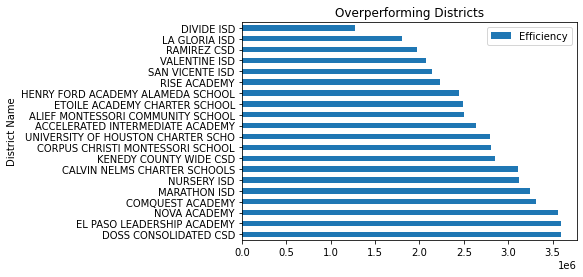

In [63]:
dfx_pass.sort_values('Efficiency', ascending=False).plot.barh(x='District Name', y='Efficiency', rot=0, title="Overperforming Districts")

<AxesSubplot:title={'center':'Underperforming Districts'}, ylabel='District Name'>

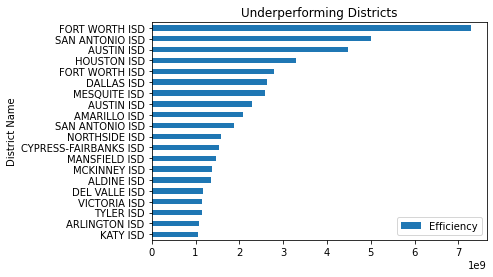

In [64]:
dfx_fail.sort_values('Efficiency', ascending=True).plot.barh(x='District Name', y='Efficiency', rot=0, title="Underperforming Districts")